In [52]:
from google.colab import drive
drive.mount('/content/drive')

from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/'  #change dir to your project folder

import numpy as np
X_train = np.load('gdrive/My Drive/dataset1/acc+gyr/trainX.npy')
y_train = np.load('gdrive/My Drive/dataset1/acc+gyr/trainy.npy')
X_test = np.load('gdrive/My Drive/dataset1/acc+gyr/testX.npy')
y_test = np.load('gdrive/My Drive/dataset1/acc+gyr/testy.npy')
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Mounted at /content/drive
Mounted at /content/gdrive
(33104, 128, 6) (33104, 118) (3740, 128, 6) (3740, 118)


In [53]:
from numpy import mean
from numpy import std
from numpy import dstack
from numpy import save, load
from pandas import read_csv
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Input ,concatenate
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import LSTM, Conv1D, concatenate,GlobalMaxPooling1D,TimeDistributed, MaxPooling1D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import concatenate
from tensorflow.keras import regularizers

In [54]:
from sklearn.model_selection import train_test_split
X_training, X_validation, y_training, y_validation = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
validation_data=(X_validation, y_validation)

In [55]:
CNN_model= Sequential()
CNN_model.add(Conv1D(filters=32, kernel_size=9, strides=2, activation='relu', input_shape=(n_timesteps,n_features)))
CNN_model.add(MaxPooling1D(pool_size=2 ,strides=2))
CNN_model.add(Dropout(0.5))
CNN_model.add(Conv1D(filters=64, kernel_size=3, strides=1, activation='relu'))
CNN_model.add(Conv1D(filters=128, kernel_size=3, strides=1, activation='relu'))
CNN_model.add(MaxPooling1D(pool_size=2 ,strides=2))
CNN_model.add(Dropout(0.5))
CNN_model.add(Conv1D(filters=128, kernel_size=1, strides=1, activation='relu'))
CNN_model.add(Flatten())
CNN_model.add(Dense(n_outputs, activation='softmax'))
CNN_model.summary()
CNN_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
callbacks = [keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
CNN_model.fit(X_training, y_training, epochs=200, verbose=True, validation_data=(X_validation, y_validation), batch_size=128,callbacks=callbacks)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_32 (Conv1D)          (None, 60, 32)            1760      
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 30, 32)           0         
 g1D)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 30, 32)            0         
                                                                 
 conv1d_33 (Conv1D)          (None, 28, 64)            6208      
                                                                 
 conv1d_34 (Conv1D)          (None, 26, 128)           24704     
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 13, 128)          0         
 g1D)                                                

In [56]:
loss, accuracy = CNN_model.evaluate(X_validation, y_validation, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = CNN_model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy: {:.4f}".format(accuracy))

Validation Accuracy:  0.9562
Testing Accuracy: 0.8917


In [57]:
CNN_model.trainable = False

LSTM_model= Sequential()
LSTM_model.add(LSTM(512,input_shape=(n_timesteps,n_features),return_sequences=True))
LSTM_model.add(LSTM(256))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Dense(128, activation='relu'))
LSTM_model.add(Dense(n_outputs, activation='relu'))
LSTM_model.summary()

inputs = Input(shape=(n_timesteps,n_features))
mergedInput= concatenate([CNN_model(inputs),LSTM_model(inputs)])
out = Dense(n_outputs, activation='softmax')(mergedInput)
model3 = Model(inputs,out)
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model3.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_19 (LSTM)              (None, 128, 512)          1062912   
                                                                 
 lstm_20 (LSTM)              (None, 256)               787456    
                                                                 
 dropout_27 (Dropout)        (None, 256)               0         
                                                                 
 dense_35 (Dense)            (None, 128)               32896     
                                                                 
 dense_36 (Dense)            (None, 118)               15222     
                                                                 
Total params: 1,898,486
Trainable params: 1,898,486
Non-trainable params: 0
_________________________________________________________________
Model: "model_8"
__________________________

In [58]:
history = model3.fit(X_training, y_training, epochs=200, verbose=True, validation_data=(X_validation, y_validation), batch_size=128,callbacks=callbacks)

Epoch 1/200
207/207 [==============================] - 20s 82ms/step - loss: 2.3526 - accuracy: 0.4057 - val_loss: 1.2147 - val_accuracy: 0.6757
Epoch 2/200
207/207 [==============================] - 16s 78ms/step - loss: 0.8778 - accuracy: 0.7679 - val_loss: 0.6470 - val_accuracy: 0.8355
Epoch 3/200
207/207 [==============================] - 17s 80ms/step - loss: 0.5616 - accuracy: 0.8496 - val_loss: 0.5169 - val_accuracy: 0.8615
Epoch 4/200
207/207 [==============================] - 16s 80ms/step - loss: 0.4106 - accuracy: 0.8893 - val_loss: 0.4064 - val_accuracy: 0.8946
Epoch 5/200
207/207 [==============================] - 16s 79ms/step - loss: 0.3360 - accuracy: 0.9088 - val_loss: 0.3468 - val_accuracy: 0.9035
Epoch 6/200
207/207 [==============================] - 16s 78ms/step - loss: 0.2992 - accuracy: 0.9167 - val_loss: 0.2793 - val_accuracy: 0.9255
Epoch 7/200
207/207 [==============================] - 16s 78ms/step - loss: 0.2281 - accuracy: 0.9361 - val_loss: 0.2180 - val_ac

In [59]:
loss, accuracy = model3.evaluate(X_validation, y_validation, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))
loss, accuracy = model3.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy: {:.4f}".format(accuracy))

Validation Accuracy:  0.9722
Testing Accuracy: 0.9110


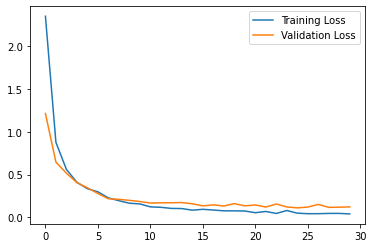

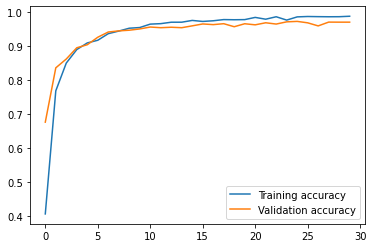

In [61]:
from matplotlib import pyplot as plt
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()
from matplotlib import pyplot as plt
plt.plot(history.history["accuracy"], label="Training accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.legend()
plt.show()